### Clustering on Encoding Score by Convex Non-negative Matrix Factorization(CNMF)

In [1]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import pickle
from brain_encoding.convex_nonnegative_matrix_factorization import smoothConvexNMF, calculate_cnmf_r_squared

In [2]:
file_name = "../data/example_encoding_score.pkl"
with open(file_name, "rb") as file:  
    V = pickle.load(file)  # shape = (num_time_points, nums_electrodes)

The coefficient of determination of CNMF:
$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}=1-\frac{\sum(X-\hat{X})^2}{\sum(X_i-\bar{X})^2}$$

In [3]:
W, H, cost = smoothConvexNMF(V, 2, beta= 0.001, max_iter= 2000)
print(V.shape, W.shape, H.shape)
print(cost[-1])
F = np.matmul(V, W)
V_hat = np.matmul(F, H)
r2_cnmf = calculate_cnmf_r_squared(V, V_hat)
print("CNMF r2: ", r2_cnmf)

  0%|          | 0/2000 [00:00<?, ?it/s]

(200, 785) (785, 2) (2, 785)
0.015977178269440822
CNMF r2:  0.9049213006047214


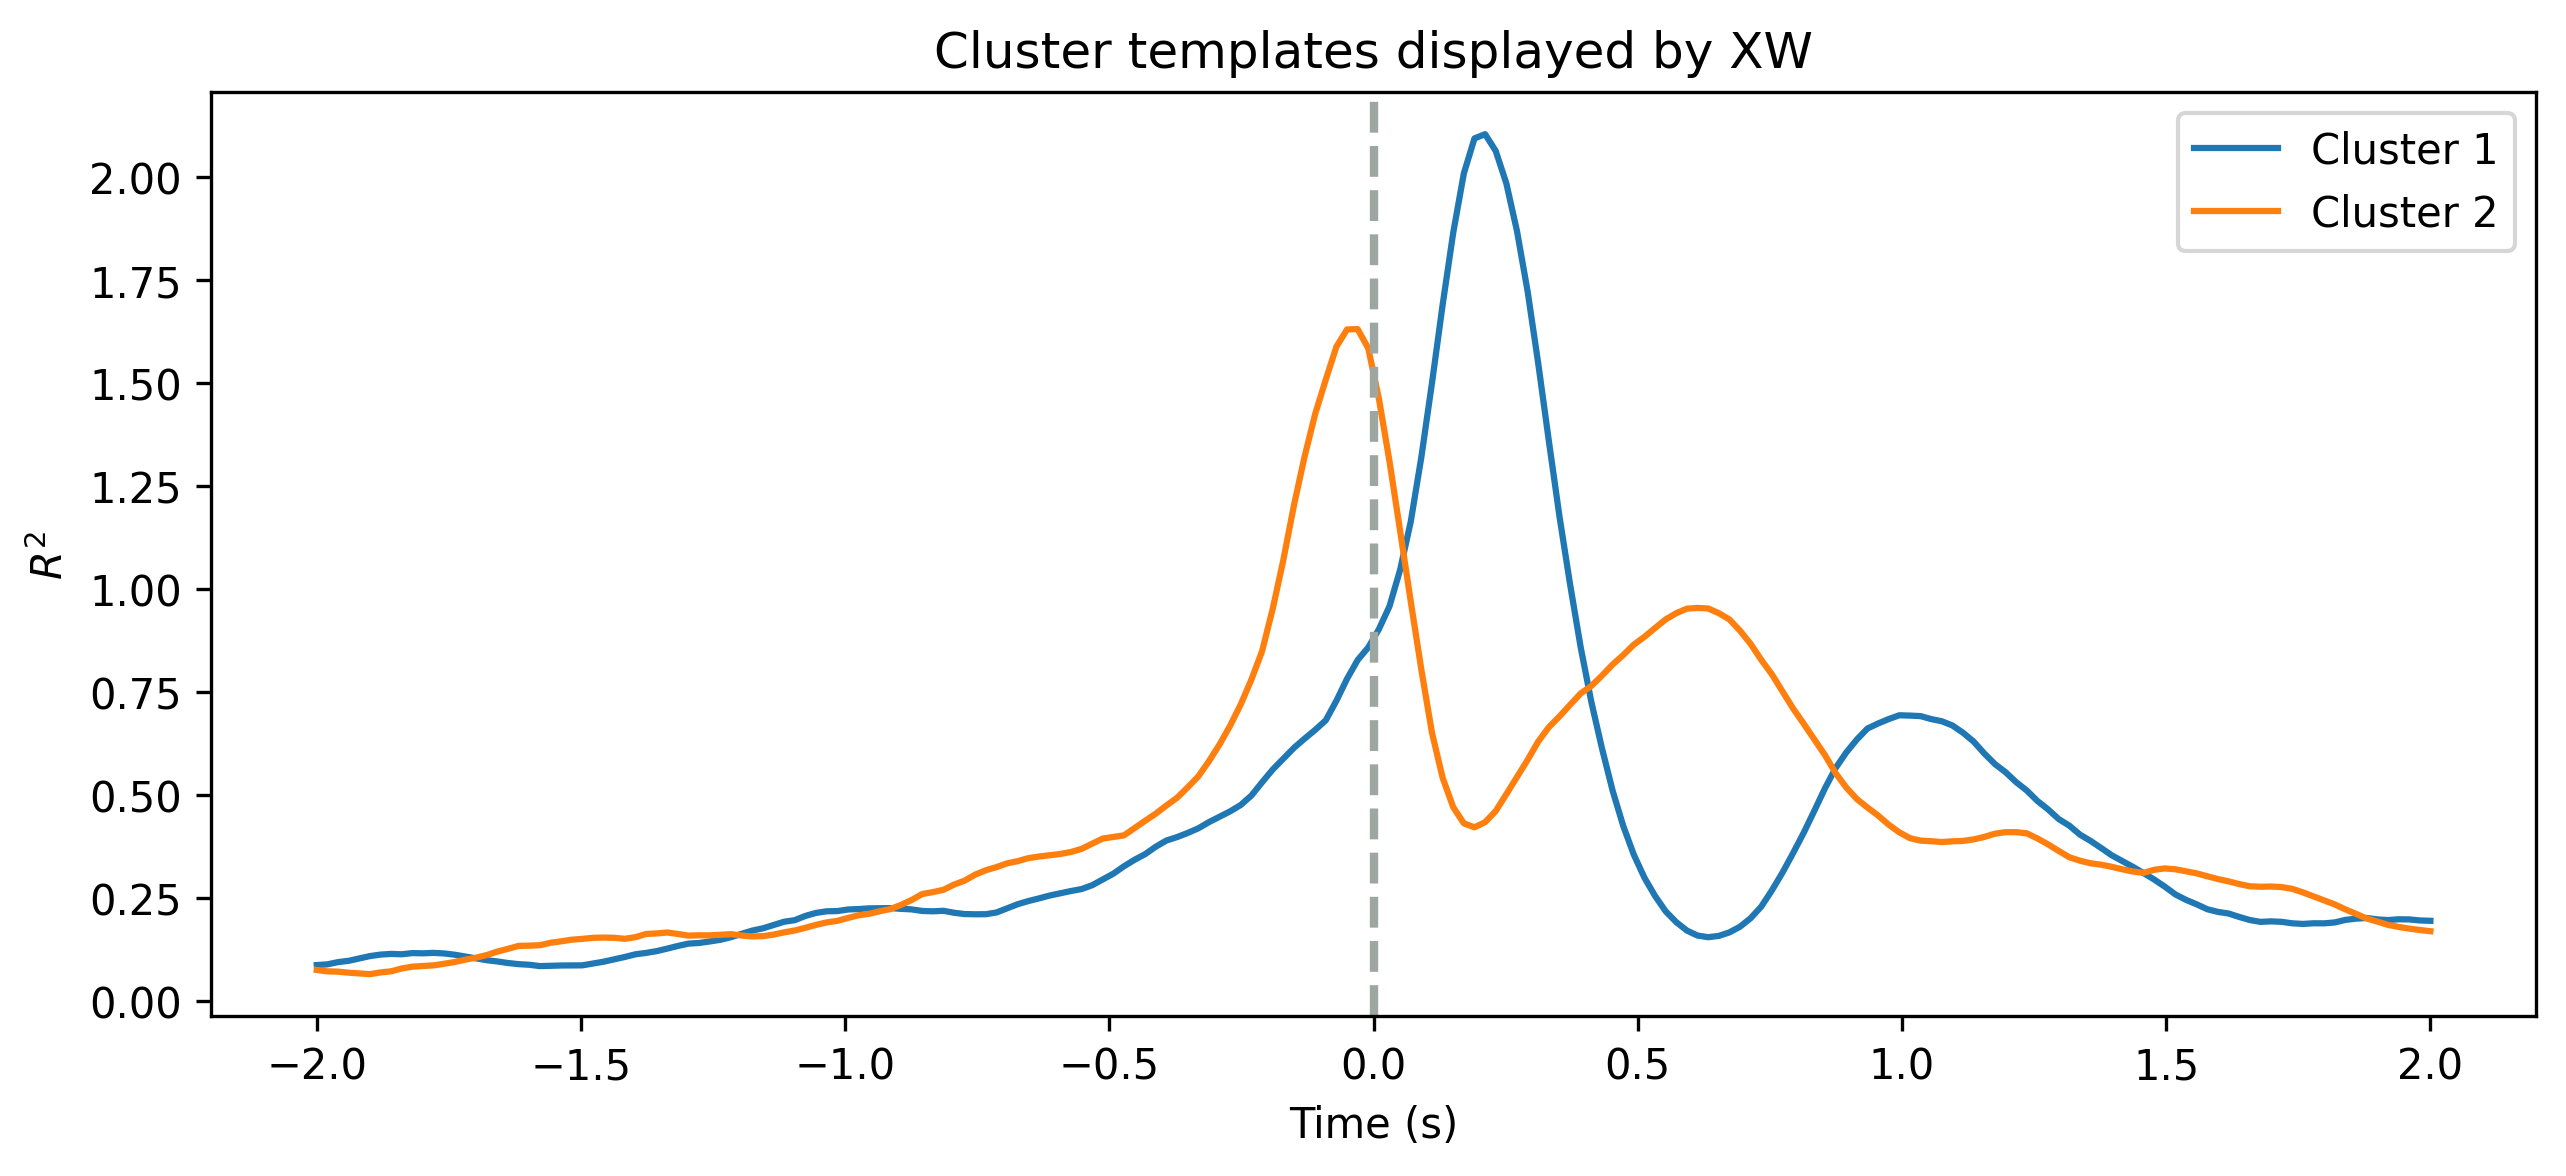

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

F = np.matmul(V, W)
plt.figure(figsize=(10,4),dpi= 300)
time = np.linspace(-2, 2, F.shape[0])

for i in range(F.shape[1]):
        plt.plot(time, F[:,i], label=f'Cluster {i+1}')


plt.axvline(0, linewidth=2, linestyle="--", color="#9EA6A1")
plt.legend(loc='upper right')
plt.xlabel('Time (s)')
plt.ylabel('$R^2$')
plt.title('Cluster templates displayed by XW')

plt.show()

#### Word trajectory of encoding score
* state-space representation for all electrodes projected onto two cluster (for our work, i.e. onset and sustained population activity) during single sentences
* Each trajectory within the space represents one sentence

In [13]:

# Classify electrodes based on H
classifications = np.argmax(H, axis=0)

# Split X into two matrices based on the classifications
X1 = V[:, classifications == 0]   
X2 = V[:, classifications == 1] 
print(H.shape)
print(X1.shape, X2.shape)

# Select electrodes from W based on classifications
W1 = W[classifications == 0, 0]
W2 = W[classifications == 1, 1]

X1W1 = X1 @ W1
X2W2 = X2 @ W2


(2, 785)
(200, 331) (200, 454)


(200, 2)


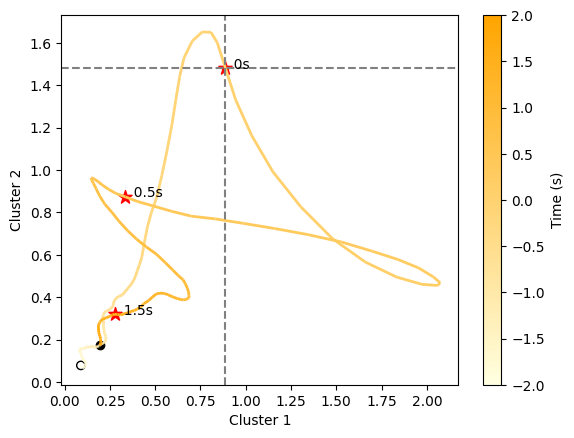

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap


# (200, 2) array data
XY = np.column_stack((X1W1, X2W2))
print(XY.shape)
# Create time values from -2 to 2
time_values = np.linspace(-2, 2, XY.shape[0])

# Create a set of line segments so that we can color them individually
points = np.array([XY[:, 0], XY[:, 1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a continuous norm to map from time points to colors
norm = plt.Normalize(time_values.min(), time_values.max())

# Create a custom color map
cmap = LinearSegmentedColormap.from_list("custom", ["lightyellow", "orange"], N=200)

lc = LineCollection(segments, cmap = cmap, norm = norm)

# Set the values used for color mapping
lc.set_array(time_values)
lc.set_linewidth(2)

fig, ax = plt.subplots()
line = ax.add_collection(lc)

# Add start and end markers
plt.scatter(XY[0, 0], XY[0, 1], color='black', facecolors='none')  # Start marker (empty circle)
plt.scatter(XY[-1, 0], XY[-1, 1], color='black')  # End marker (filled circle)
ax.set_xlabel('Cluster 1')
ax.set_ylabel('Cluster 2')
# Add vertical and horizontal dashed lines at the 100th point
plt.axvline(XY[100, 0], color='grey', linestyle='--')
plt.axhline(XY[100, 1], color='grey', linestyle='--')

# Add markers at specified time points
for t in [0, 0.5, 1.5]:   # Specific time marker
    # Find the index of the closest time point
    idx = np.abs(time_values - t).argmin()
    plt.scatter(XY[idx, 0], XY[idx, 1], color='red', marker='*', s=100)  # Add a star marker
    plt.text(XY[idx, 0], XY[idx, 1], f'  {t}s')  # Add a text annotation

fig.colorbar(line, ax=ax, label='Time (s)')

# Display the plot
plt.show()
# This picture can explain the first peak and second peak in wav2vec2